In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [96]:
# load the data
game = pd.read_csv('topline_metrics.csv', sep=',')

## 1 Exploratory data analysis

#### 1.1 Dataframe

In [97]:
# check a few lines
game.head()

,Date,Date.1,Platform,Country,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds)
0,2018-03-15,2018-03-15,Android(All),Kazakhstan(哈萨克斯坦),628852.81,15498.31,43429.11,3428.09,17.58,1.3,2.3,4527.01,79.12,58.18
1,2018-03-15,2018-03-15,ALL,United States(美国),633293.54,19939.05,43429.11,3428.09,17.58,1.3,2.3,4527.01,75.65,58.87
2,2018-03-15,2018-03-15,Android(All),Kazakhstan(哈萨克斯坦),628852.81,15498.31,43429.11,3428.09,17.58,1.3,2.3,4527.01,79.12,58.18
3,2018-03-15,2018-03-15,ALL,Guatemala(危地马拉),628976.03,15621.54,43429.11,3428.09,17.58,1.3,2.3,4527.01,74.62,46.21
4,2018-03-15,2018-03-15,Android(All),Belarus(白俄罗斯),629154.54,15800.04,43429.11,3428.09,17.58,1.3,2.3,4527.01,76.97,56.92


**Note**: seems to have similar column "Date"

In [4]:
# check the size
game.shape

(748264, 14)

In [5]:
# check missing values
game.isnull().sum()

Date                           0
Date.1                         0
Platform                       0
Country                        0
TRU                            0
DAU                            0
Items                          0
Trans                          0
Items Per Trans                0
Items per DAU                  0
Conversion                     0
Cash Flow                      0
Return Customer                0
Time Spend Per Day(seconds)    0
dtype: int64

In [6]:
# check data types
game.dtypes

Date                            object
Date.1                          object
Platform                        object
Country                         object
TRU                            float64
DAU                            float64
Items                          float64
Trans                          float64
Items Per Trans                float64
Items per DAU                  float64
Conversion                     float64
Cash Flow                      float64
Return Customer                float64
Time Spend Per Day(seconds)    float64
dtype: object

#### 1.2 Columns

In [7]:
# check unique values for categorical/date data
game.Date.value_counts().sort_index()

2018-03-15     470
2018-03-16     553
2018-03-17     786
2018-03-18     840
2018-03-19     838
              ... 
2020-03-05    1107
2020-03-06    1033
2020-03-07    1071
2020-03-08    1067
2020-03-09    1027
Name: Date, Length: 724, dtype: int64

**Note**: Data from 2018-03-15 to 2020-03-09

In [8]:
# check similarity between Date and Date.1
date = game[['Date','Date.1']]
date['compare'] = np.where(date['Date']==date['Date.1'],0,1)
date['compare'].sum()

0

**Note**: Same columns, should be removed

In [9]:
game.Country.value_counts()

Iran(伊朗)           3441
Australia(澳大利亚)    3434
圣卢西亚               3366
Israel(以色列)        3365
Iraq(伊拉克)          3363
                   ... 
厄立特里亚               529
托克劳                 496
圣巴泰勒米               239
unknown(未知)          31
蒙塞拉特岛                18
Name: Country, Length: 239, dtype: int64

**Note**: Inconsistent country names format (in different language or bilingual)

In [10]:
game.Platform.value_counts()

ALL             251675
Android(All)    250692
IOS(All)        245897
Name: Platform, dtype: int64

**Note**: Not all countries have the same amount of records for different platforms

In [11]:
# Check stats for continuous values
game.describe()

,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds)
count,7.482640e+05,7.482640e+05,7.482640e+05,748264.00000,748264.000000,748264.000000,748264.000000,748264.000000,748264.000000,748264.000000
mean,7.399568e+05,1.816949e+04,5.089120e+04,3958.49364,31.569433,1.414330,2.902036,5093.453512,39.795054,122.605716
std,6.776595e+05,1.801799e+04,4.610241e+04,3655.62504,23.629177,1.208879,2.591666,4712.790645,24.796009,43.331318
min,6.286478e+05,1.529217e+04,4.342911e+04,3428.09000,17.580000,1.300000,2.300000,4527.010000,12.210000,-9.990000
25%,6.288102e+05,1.529677e+04,4.342911e+04,3428.09000,17.580000,1.300000,2.300000,4527.010000,28.660000,98.950000
50%,6.314452e+05,1.537393e+04,4.352124e+04,3433.85000,28.090000,1.320000,2.560000,4532.770000,39.430000,118.180000
75%,6.574735e+05,1.617663e+04,4.466021e+04,3522.53000,36.080000,1.390000,3.000000,4611.080000,48.920000,139.370000
max,2.677675e+07,2.141935e+06,4.387412e+06,434846.58000,1744.870000,444.240000,232.630000,819825.280000,3912.090000,1390.060000


**Note**: Invalid values based on business rules

1. max(Conversion rate) > 100
2. min(Time spent per day) < 0

**Note**: Notice anomalous large values in "max" that exceeds [mean-3std, mean+3std]

In [65]:
# box plot for each column to validate
#for col in game.columns[4:]:
#    game.boxplot(column=col)
#    plt.show()

#### 1.3 Rows

In [98]:
#repeated rows
game1 = game.copy()
game1['duplicate'] = game1.duplicated()

In [99]:
game1[game1['duplicate']==True].shape

(360977, 15)

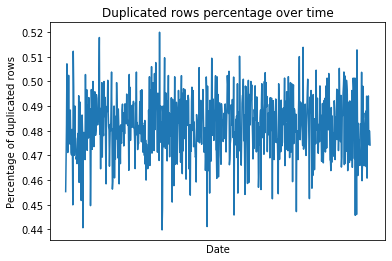

In [15]:
# check percentage of duplication by dates
dup = game1.groupby('Date').sum().duplicate
count = game1.groupby('Date').count().duplicate
plt.plot(dup.index, dup.values/count.values)
plt.title('Duplicated rows percentage over time')
plt.xlabel('Date')
plt.ylabel('Percentage of duplicated rows')
plt.tick_params(axis='x',labelbottom=False,bottom=False)
plt.show()

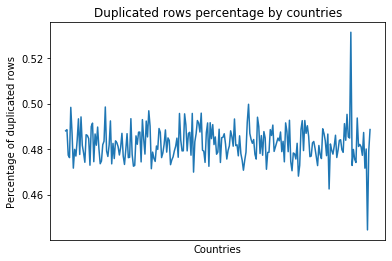

In [16]:
# check percentage of duplication by countries
dup1 = game1.groupby('Country').sum().duplicate
count1 = game1.groupby('Country').count().duplicate
plt.plot(dup1.index, dup1.values/count1.values)
plt.title('Duplicated rows percentage by countries')
plt.xlabel('Countries')
plt.ylabel('Percentage of duplicated rows')
plt.tick_params(axis='x',labelbottom=False,bottom=False)
plt.show()

**Note**:
1. Duplicated rows largely exist in the dataset. There were around 361k duplicated rows, nearly 50% of the data
2. 40%~50% duplicated records occur every day
3. 45%~52% duplicated records occur in every country

**Note**: 

   Interestingly, there is a country having conflicting rows (same date, same country, same platform, different values for DAU/TRU/etc), see 1.5: data wrangling

#### 1.4 Pairwise

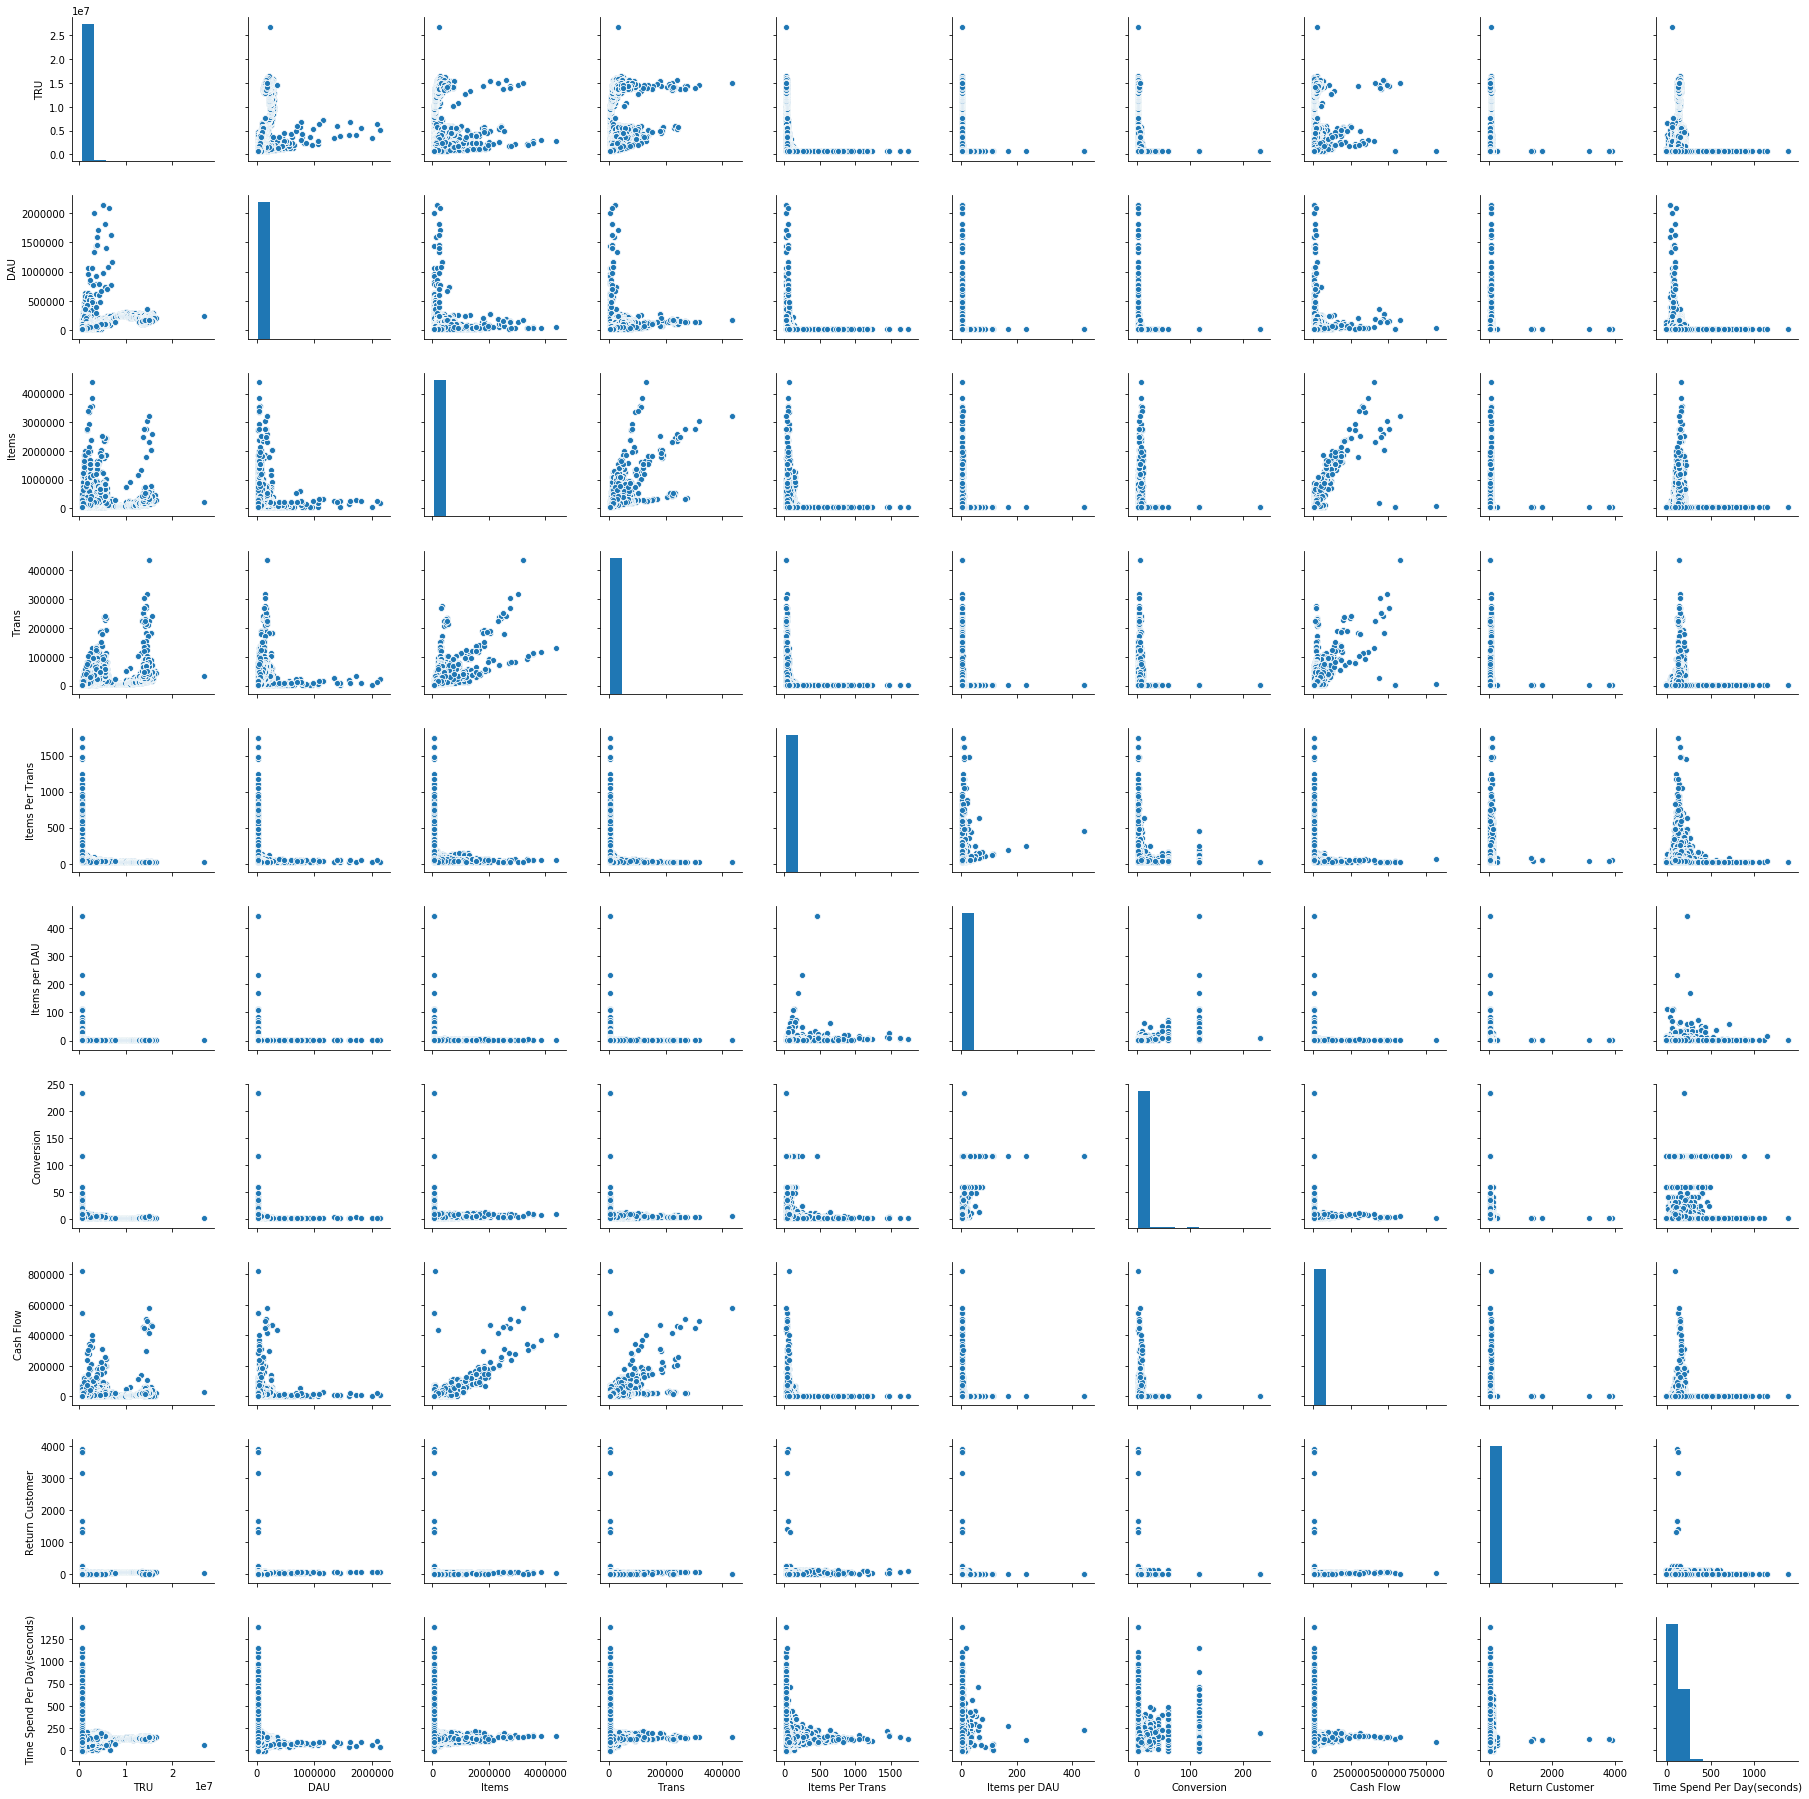

In [14]:
# pairwise relationship and value distribution
# Attention: take around 10min
sns.pairplot(game)

**Note**: initial conclusion/assumption
    
1. From the **diagonal** - For all columns, most data points are concentrated around a certain range, with a few extremely large outliers 

2. From the **line shape** - possible linear relationship between trans ～ cash flow

3. From the **L shape** (the most prevailing shape) and also some **U shape** in the first column - concentrated data and 2 possible clusters

4. From the **E shape** - possible 3 clusters; require further investigation

#### 1.5 Data wrangling before the next step

In [100]:
# remove duplicated columns
game1 = game1.drop(columns=['Date.1'])

# remove data not conform to business rules
# remove duplicated rows
game2 = game1[(game1.Conversion<=100)&
             (game1['Time Spend Per Day(seconds)']>=0)&
             (game1['duplicate']==False)].copy()

In [101]:
game2 = game2.drop(columns=['duplicate'])

In [102]:
# clean the 'Country' column to unify the format
game2 = pd.concat([game2, game2['Country'].str.split('(', expand=True)], axis=1)
game2.drop(columns=[1,2,3,'Country'],inplace=True)
game2.rename(columns={0:'Country'},inplace=True)

In [81]:
# Translation: incomplete-time consuming

# game2.Country.sort_values().unique()
# cn_name = ['厄立特里亚', '图瓦卢', '圣卢西亚', '圣巴泰勒米',
#       '基里巴斯', '托克劳', '朝鲜', '根西岛', '瓦利斯和富图纳', '瓦努阿图', '福克兰群岛', '科摩罗',
#       '美属萨摩亚', '英属印度洋领地', '英属维尔京群岛', '萨摩亚', '蒙塞拉特岛', '诺福克岛', '马约特']

In [80]:
# take around 5.5h
#-------------------
# TerryYin translate
# from translate import Translator
# translator = Translator(to_lang='en', from_lang = 'zh')

#-------------------
# Google translate
#from googletrans import Translator
#translator = Translator()

#-------------------
# cn_country = game2[game2.Country.isin(cn_name)]

#####
# cn_country['Country'] = country['Country'].map(lambda x: translator.translate(x))
# or
# cn_country['Country'] = country['Country'].(lambda x: translator.translate(x, src="zh-CN", dest="en").text)
#####

# en_country = game2[~game2.Country.isin(cn_name)].copy()
# game_data = pd.concat([en_country, cn_country], ignore_index=True)

#-------------------
# test case 
# cn_country = game2[game2.Country=='蒙塞拉特岛']

#####
# cn_country['Country'] = country['Country'].(lambda x: translator.translate(x, src="zh-CN", dest="en").text)
# or
# cn_country['Country'] = country['Country'].map(lambda x: translator.translate(x))
#####

In [103]:
# check data shape
game2.shape

(386646, 13)

In [104]:
# check data integrity
check = game2.groupby(['Country','Date']).count()
check[check.Platform>3]

Platform  TRU  DAU  Items  Trans  Items Per Trans  \
Country  Date                                                            
Dominica 2018-03-16         4    4    4      4      4                4   
         2018-03-19         5    5    5      5      5                5   
         2018-03-20         5    5    5      5      5                5   
         2018-03-22         5    5    5      5      5                5   
         2018-03-23         5    5    5      5      5                5   
...                       ...  ...  ...    ...    ...              ...   
         2020-03-05         6    6    6      6      6                6   
         2020-03-06         5    5    5      5      5                5   
         2020-03-07         5    5    5      5      5                5   
         2020-03-08         4    4    4      4      4                4   
         2020-03-09         4    4    4      4      4                4   

                     Items per DAU  Conversion  Cash Flow  Return Customer  \
Country  Date                                                                
Dominica 2018-03-16              4           4          4                4   
         2018-03-19              5           5          5                5   
         2018-03-20              5           5          5                5   
         2018-03-22              5           5          5                5   
         2018-03-23              5           5          5                5   
...                            ...         ...        ...              ...   
         2020-03-05              6           6          6                6   
         2020-03-06              5           5          5                5   
         2020-03-07              5           5          5                5   
         2020-03-08              4           4          4                4   
         2020-03-09              4           4          4                4   

                     Time Spend Per Day(seconds)  
Country  Date                                     
Dominica 2018-03-16                            4  
         2018-03-19                            5  
         2018-03-20                            5  
         2018-03-22                            5  
         2018-03-23                            5  
...                                          ...  
         2020-03-05                            6  
         2020-03-06                            5  
         2020-03-07                            5  
         2020-03-08                            4  
         2020-03-09                            4  

[629 rows x 11 columns]

**Note**: conflicting data values in the records for country Dominica.

**Action**: remove this country from the dataset and consult experts for further validation of the data source

In [105]:
# remove country Dominica
# game_data for dashboarding
game_data = game2[game2['Country']!='Dominica'].copy()

In [106]:
# remove 386646-383265 = 3381 rows from the dataset
game_data.shape

(383265, 13)

In [ ]:
game_data.to_excel("TencentNA.xlsx")

## 2 Clustering for segmentation 

#### 2.1 Data preparation for clustering

In [108]:
# Datetime variables
game3 = game_data.copy()
# extra feature extraction: date
# transform str to date
game3['Date'] = pd.to_datetime(game3['Date'])

# day of week
game3['day'] = game3['Date'].dt.dayofweek

# date
game3['date'] = game3['Date'].dt.day

# month
game3['month'] = pd.DatetimeIndex(game3['Date']).month

# year
game3['year'] = pd.DatetimeIndex(game3['Date']).year

# drop date column as it has been represented by day, month, year columns
game3 = game3.drop(columns=['Date'])


In [109]:
# Categorical variables
# transform platform into dummies
game3 = pd.get_dummies(game3, columns=['Platform'])
game3 = game3.drop(columns=['Platform_IOS(All)'])

# transform countries into dummies
game3 = pd.get_dummies(game3, columns=['Country'])
game3 = game3.drop(game3.columns[-1],axis=1)

In [140]:
game3

,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds),...,Country_瓦利斯和富图纳,Country_瓦努阿图,Country_福克兰群岛,Country_科摩罗,Country_美属萨摩亚,Country_英属印度洋领地,Country_英属维尔京群岛,Country_萨摩亚,Country_蒙塞拉特岛,Country_诺福克岛
0,628852.81,15498.31,43429.11,3428.09,17.58,1.30,2.30,4527.01,79.12,58.18,...,0,0,0,0,0,0,0,0,0,0
1,633293.54,19939.05,43429.11,3428.09,17.58,1.30,2.30,4527.01,75.65,58.87,...,0,0,0,0,0,0,0,0,0,0
3,628976.03,15621.54,43429.11,3428.09,17.58,1.30,2.30,4527.01,74.62,46.21,...,0,0,0,0,0,0,0,0,0,0
4,629154.54,15800.04,43429.11,3428.09,17.58,1.30,2.30,4527.01,76.97,56.92,...,0,0,0,0,0,0,0,0,0,0
5,628648.96,15294.47,43429.11,3428.09,17.58,1.30,2.30,4527.01,127.37,101.95,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748244,630572.21,15319.81,45428.36,3516.77,43.55,2.49,7.61,4644.48,12.21,126.94,...,0,0,0,0,0,0,0,0,0,0
748246,631868.96,15350.90,44869.81,3517.92,36.05,1.81,5.51,4787.29,12.21,211.93,...,0,0,0,0,0,0,0,0,0,0
748251,628650.12,15292.17,43429.11,3428.09,17.58,1.30,2.30,4527.01,12.21,61.87,...,0,0,0,0,0,0,0,0,0,0
748253,680061.80,16572.79,61476.52,4819.28,32.51,1.70,5.42,6013.79,12.21,145.94,...,0,0,0,0,0,0,0,0,0,0


In [110]:
X = game3.values

In [139]:
X.shape

(383265, 252)

#### 2.2 Find out the best k

The conclusion/assumption in 1-4 suggests that possible values for k could be 2 or 3. 

Here the elbow method is applied to the dataset, to further validate the selection of k by computing the **Within-Cluster-Sum of Squared Errors (WSS)**

In [113]:
# find out the best k for k-means

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [114]:
# compute SSE
# take some time
kmax = 5
sse = calculate_WSS(X, kmax)

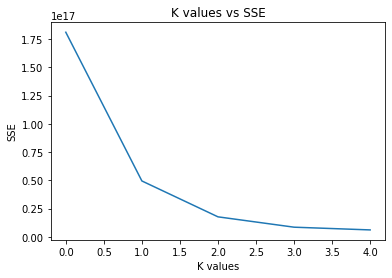

In [115]:
# plot to find out the elbow point
plt.plot(np.arange(kmax),sse)
plt.title('K values vs SSE')
plt.xlabel('K values')
plt.ylabel('SSE')
plt.show()

The elbow point validates the previous assumption that 2 or 3 can be good options for k. 

Here, **k=3** is selected for later analysis.

#### 2.3 K-means clustering

In [116]:
# Fit the model
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

In [238]:
# Evaluation: calculate silhouette_score
# Take a long time!
# print(silhouette_score(X, kmeans.labels_))

0.9194291375101088


Pretty good score for clustering performance!

#### 2.4 Examine clusters

In [117]:
# Get the cluster labels
game_cluster = game_data.copy()
game_cluster['label'] = kmeans.labels_

In [118]:
game_cluster.label.value_counts()

0    377101
2      5390
1       774
Name: label, dtype: int64

In [119]:
cluster1 = game_cluster[game_cluster['label']==0]
cluster2 = game_cluster[game_cluster['label']==1]
cluster3 = game_cluster[game_cluster['label']==2]

## 3 Anomaly detection within clusters - isolation forest

In [126]:
# input: 3 parameters
def isolation_forest(df, columns, outliers_fraction):
    data = df[columns] # extract data
    scaler = StandardScaler() 
    np_scaled = scaler.fit_transform(data) 
    data = pd.DataFrame(np_scaled) # scaled data
    
    model =  IsolationForest(contamination=outliers_fraction)
    model.fit(data) # train isolation forest
    
    # attach anomaly label
    # 0: normal, 1: anomaly
    df['anomaly'] = np.array(pd.Series(model.predict(data)))
    df['anomaly'] = df['anomaly'].map( {1: 0, -1: 1} )
    
    # return dataframe with anomaly label
    return df

In [135]:
cluster1.columns[2:12]

Index(['TRU', 'DAU', 'Items', 'Trans', 'Items Per Trans', 'Items per DAU',
       'Conversion', 'Cash Flow', 'Return Customer',
       'Time Spend Per Day(seconds)'],
      dtype='object')

In [127]:
# anomaly column for cluster1
cluster1 = isolation_forest(cluster1, cluster1.columns[2:12],0.05)

In [128]:
# anomaly column for cluster2
cluster2 = isolation_forest(cluster2, cluster1.columns[2:12],0.05)

In [129]:
# anomaly column for cluster3
cluster3 = isolation_forest(cluster3, cluster3.columns[2:12],0.05)

In [130]:
cluster1.anomaly.value_counts()

0    358246
1     18855
Name: anomaly, dtype: int64

In [131]:
cluster2.anomaly.value_counts()

0    735
1     39
Name: anomaly, dtype: int64

In [132]:
cluster3.anomaly.value_counts()

0    5120
1     270
Name: anomaly, dtype: int64

In [136]:
finaldata = pd.concat([cluster1,cluster2,cluster3], ignore_index=True)
finaldata.shape

(383265, 15)

In [137]:
finaldata.head()

,Date,Platform,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds),Country,label,anomaly
0,2018-03-15,Android(All),628852.81,15498.31,43429.11,3428.09,17.58,1.3,2.3,4527.01,79.12,58.18,Kazakhstan,0,0
1,2018-03-15,ALL,633293.54,19939.05,43429.11,3428.09,17.58,1.3,2.3,4527.01,75.65,58.87,United States,0,0
2,2018-03-15,ALL,628976.03,15621.54,43429.11,3428.09,17.58,1.3,2.3,4527.01,74.62,46.21,Guatemala,0,0
3,2018-03-15,Android(All),629154.54,15800.04,43429.11,3428.09,17.58,1.3,2.3,4527.01,76.97,56.92,Belarus,0,0
4,2018-03-15,Android(All),628648.96,15294.47,43429.11,3428.09,17.58,1.3,2.3,4527.01,127.37,101.95,Ghana,0,0


In [138]:
finaldata.to_excel("timeseries.xlsx")